In [1]:
%cd ..

/Users/erwan/Programmes/2022 Datacamp/solar_wind


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss, classification_report

from display import plot_event, multiple_plots, consecutive_plots, display_timeline, show_densities
from problem import get_train_data, get_test_data
from problem import turn_prediction_to_event_list


In [54]:
data_train, labels_train = get_train_data()
data_test, labels_test = get_test_data()

df_train = data_train[['Beta']].copy()
df_test = data_test[['Beta']].copy()

In [55]:
seuil_beta = 50
beta_train_s =  df_train['Beta'].map(lambda x: min(x, seuil_beta))
beta_test_s = df_test['Beta'].map(lambda x: min(x, seuil_beta))

# thresh_and_stand_beta = (thresh_beta_s - thresh_beta_s.min()) / thresh_beta_s.max()
# display_timeline(beta_train_s, labels_train)
# display_timeline(beta_test_s, labels_test)

In [303]:
def get_fe_data(var_s):

    # Moyenne mobile faible sur les valeurs pour espérer réduire dors et déjà le bruit 
    var_s = var_s.rolling('30 min', center=True).mean()

    # Différence entre moyenne longue et moyenne courte (mobiles) 
    # Met en avant les transitions entre états
    var_l_2h_s = var_s.rolling('2h').mean()
    var_r_2h_s = var_s.iloc[::-1].rolling('2h').mean().iloc[::-1]

    # Ratio entre une moyenne mobile courte et une très longue
    # Met en avant les valeurs faibles de Beta
    var_4h_s = var_s.rolling('4h', center=True).mean()
    var_long_s = var_s.rolling('4 d', center=True).mean()

    var_l_20h_s = var_s.rolling('20h').mean()
    var_r_20h_s = var_s.iloc[::-1].rolling('20h').mean().iloc[::-1]

    df = pd.DataFrame({})
    df['base-value'] = var_s
    df['long-mean'] = var_s.rolling('168 h', center=True).mean()

    df['l_small_avg'] = var_l_2h_s.copy()
    df['r_small_avg'] = var_r_2h_s.copy()
    df['diff-mean'] = (df['r_small_avg'] - df['l_small_avg']).abs()

    df['mean-ratio'] = var_4h_s / var_long_s

    df['l_global_avg'] = var_l_20h_s.copy()
    df['r_global_avg'] = var_r_20h_s.copy()

    return df

In [304]:
def display_res(data_test, labels_test, models):
    for model in models:
        y_pred = model.predict_proba(data_test)
        print('Y_pred shape :', y_pred.shape)
        # print('Y_pred : \n', y_pred[:5])

        loss = log_loss(labels_test, y_pred)
        print("Loss :", loss)
        print(classification_report(labels_test, y_pred.argmax(axis=1)))
        print('-------------')

In [305]:
fe_train_data = get_fe_data(beta_train_s)
fe_test_data = get_fe_data(beta_test_s)

small_fe_train_data = fe_train_data.drop(columns=['l_small_avg', 'r_small_avg'])
small_fe_test_data = fe_test_data.drop(columns=['l_small_avg', 'r_small_avg'])

In [306]:
fe_train_data.head()

,base-value,long-mean,l_small_avg,r_small_avg,diff-mean,mean-ratio,l_global_avg,r_global_avg
1997-10-01 00:00:00,8.395598,0.788907,8.395598,9.201718,0.806121,14.461996,8.395598,1.338419
1997-10-01 00:10:00,9.571798,0.788677,8.983698,8.543898,0.439800,13.486491,8.983698,1.268953
1997-10-01 00:20:00,12.369014,0.788341,10.112137,7.784553,2.327584,12.637000,10.112137,1.190002
1997-10-01 00:30:00,12.736992,0.787880,10.768350,6.797346,3.971004,11.885239,10.768350,1.087947
1997-10-01 00:40:00,13.128955,0.787384,11.240471,5.781437,5.459034,11.216886,11.240471,0.982966


In [300]:
small_fe_train_data.head()

,base-value,long-mean,diff-mean,mean-ratio,l_global_avg,r_global_avg
1997-10-01 00:00:00,8.395598,2.067342,0.806121,14.461996,8.395598,1.338419
1997-10-01 00:10:00,9.571798,2.047604,0.439800,13.486491,8.983698,1.268953
1997-10-01 00:20:00,12.369014,2.026661,2.327584,12.637000,10.112137,1.190002
1997-10-01 00:30:00,12.736992,2.004624,3.971004,11.885239,10.768350,1.087947
1997-10-01 00:40:00,13.128955,1.982904,5.459034,11.216886,11.240471,0.982966


### Modèles

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

In [61]:
log_reg_model = LogisticRegression(
    'l2',
)

log_reg_model.fit(fe_train_data, labels_train)
log_reg_model.coef_

array([[ 1.25639518, -6.19699049, -6.11041614,  5.82282206,  0.15213744]])

In [24]:
random_f_model = RandomForestClassifier(
    n_estimators=100,
    random_state=2
)

random_f_model.fit(fe_train_data, labels_train)

RandomForestClassifier()

In [47]:
random_f_model.feature_importances_

array([0.20156843, 0.28399145, 0.2305021 , 0.11466548, 0.16927254])

In [129]:
hist_xgboost_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=1000,
    random_state=2
)

hist_xgboost_model.fit(fe_train_data[cols], labels_train)
hist_xgboost_model

HistGradientBoostingClassifier(learning_rate=0.05, max_iter=1000,
                               random_state=2)

### Evaluation et Tests


 Nouveau modèle 

Y_pred shape : (205574, 2)
Loss : 0.12579004537450503
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    191755
           1       0.78      0.38      0.51     13819

    accuracy                           0.95    205574
   macro avg       0.87      0.69      0.74    205574  
   weighted avg    0.95      0.95      0.94    205574

### Tests sur la régression logistique

In [65]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

- Conclusion : pour la base de données avec Beta seulement standardiser les données n'est pas utile

In [ ]:
log_model = LogisticRegression(
    penalty='l2',
    C=1,
    max_iter=1000,
    random_state=0,
)
# Avec une pénalisartion et sans StandardScaler
log_reg = make_pipeline(log_model)
log_reg.fit(fe_train_data, labels_train)
print('Coefs', log_reg['logisticregression'].coef_)
display_res(fe_test_data, labels_test, [log_reg])

- Conclusion : Pas de différence avec et sans pénalisation. Même remarque pour standardScaler

## Sélection de colonnes

In [334]:
drop_fe_train = fe_train_data[labels_train == 0].sample(frac=0.55, random_state=1)

reduce_fe_data_train = fe_train_data.drop(drop_fe_train.index)
reduce_fe_labels_train = labels_train[reduce_fe_data_train.index]

print('Len Reduce_fe :', len(reduce_fe_data_train))
print('Nombre de 0 dans fe :', len(fe_train_data[labels_train == 0]))
print('Nombre de 1 dans fe :', len(fe_train_data[labels_train == 1]))
print('Pourcentage de 1 dans reduce_fe :', 100 * np.round(reduce_fe_labels_train.value_counts()[1] / len(reduce_fe_labels_train), 2))

reduce_fe_data_train.head(2)

Len Reduce_fe : 261636
Nombre de 0 dans fe : 451269
Nombre de 1 dans fe : 58565
Pourcentage de 1 dans reduce_fe : 22.0


,base-value,long-mean,l_small_avg,r_small_avg,diff-mean,mean-ratio,l_global_avg,r_global_avg
2003-11-03 14:10:00,1.465761,1.783098,2.181207,2.767358,0.586151,1.426862,1.450617,2.103411
2001-11-27 19:50:00,0.267498,0.346913,0.216512,0.335338,0.118826,0.998300,0.154700,0.255545


In [335]:
cols = ['base-value', 'mean-ratio', 'diff-mean', 'l_small_avg', 'r_small_avg']

log_model = LogisticRegression(
    penalty='l2',
    C=1,
    max_iter=1000,
    random_state=0,
)

print("Colonnes : ", cols)
log_reg = make_pipeline(log_model)
log_reg.fit(reduce_fe_data_train[cols], reduce_fe_labels_train)
print('Coefs :', log_reg['logisticregression'].coef_)
display_res(fe_test_data[cols], labels_test, [log_reg])

Colonnes :  ['base-value', 'mean-ratio', 'diff-mean', 'l_small_avg', 'r_small_avg']
Coefs : [[ 1.24700003  0.26181994  5.53590306 -5.90231127 -5.8820308 ]]
Y_pred shape : (205574, 2)
Loss : 0.14626763615694258
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    191755
           1       0.60      0.60      0.60     13819

    accuracy                           0.95    205574
   macro avg       0.78      0.78      0.78    205574
weighted avg       0.95      0.95      0.95    205574

-------------


In [202]:
log_model = LogisticRegression(
    penalty='l2',
    C=1,
    max_iter=1000,
    random_state=0,
)

print("Colonnes : ", cols)
log_reg = make_pipeline(log_model)
log_reg.fit(reduce_fe_data_train[cols], reduce_fe_labels_train)
print('Coefs :', log_reg['logisticregression'].coef_)
display_res(fe_test_data[cols], labels_test, [log_reg])

Colonnes :  ['base-value', 'mean-ratio', 'diff-mean', 'l_small_avg', 'r_small_avg']
Coefs : [[ 1.24700003  0.26181994  5.53590306 -5.90231127 -5.8820308 ]]
Y_pred shape : (205574, 2)
Loss : 0.14626763615694258
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    191755
           1       0.60      0.60      0.60     13819

    accuracy                           0.95    205574
   macro avg       0.78      0.78      0.78    205574
weighted avg       0.95      0.95      0.95    205574

-------------


In [189]:
histboost_model = HistGradientBoostingClassifier(
    learning_rate=1,
    max_iter=1000,
    random_state=2
)

small_hist_xgboost_model.fit(reduce_fe_data_train, reduce_fe_labels_train)

print("Colonnes : ", cols)
xgboost_clas = make_pipeline(histboost_model)
xgboost_clas.fit(reduce_fe_data_train[cols], reduce_fe_labels_train)
display_res(fe_test_data[cols], labels_test, [xgboost_clas])

Colonnes :  ['base-value', 'mean-ratio', 'diff-mean', 'l_small_avg', 'r_small_avg']
Y_pred shape : (205574, 2)
Loss : 0.15920068386852873
              precision    recall  f1-score   support

           0       0.97      0.96      0.97    191755
           1       0.55      0.63      0.59     13819

    accuracy                           0.94    205574
   macro avg       0.76      0.80      0.78    205574
weighted avg       0.94      0.94      0.94    205574

-------------


#### Calcul de __ev_prec__ et  __ev_rec__

In [205]:
from problem import turn_prediction_to_event_list, overlap_with_list, find

In [328]:
model = log_reg

In [333]:
y_pred = model.predict_proba(fe_test_data[cols]) 
s_y_pred = pd.Series(y_pred[:, 1], index=labels_test.index)

# s_y_pur 
print("ev_prec", precision(labels_test, s_y_pred))
print('ev_rec', recall(labels_test, s_y_pred))

ev_prec 0.21276595744680848
ev_rec 0.4672897196261683


In [1]:
y_pred = model.predict_proba(fe_test_data[cols]) 
s_y_pred = pd.Series(y_pred[:, 1], index=labels_test.index)
s_y_pred = s_y_pred.rolling('18 h', center=True).mean()
s_y_pred_smoothed = s_y_pred.rolling(12, min_periods=0, center=True).quantile(0.90)

# s_y_pred or s_y_pred_smoothed
print("ev_prec", precision(labels_test, s_y_pred_smoothed))
print('ev_rec', recall(labels_test, s_y_pred_smoothed))

NameError: name 'model' is not defined

<AxesSubplot: >

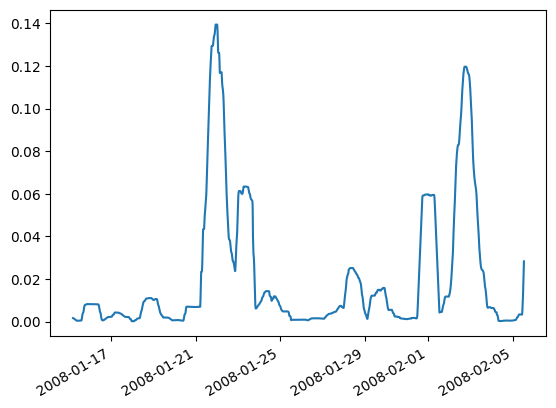

In [285]:
s_y_pred = pd.Series(y_pred[:, 1], index=labels_test.index)
s_y_pred = s_y_pred.rolling('18 h', center=True).mean()
s_y_pred_smoothed = s_y_pred.rolling(12, min_periods=0, center=True).quantile(0.90).iloc[2000:5000]
s_y_pred_smoothed.plot()

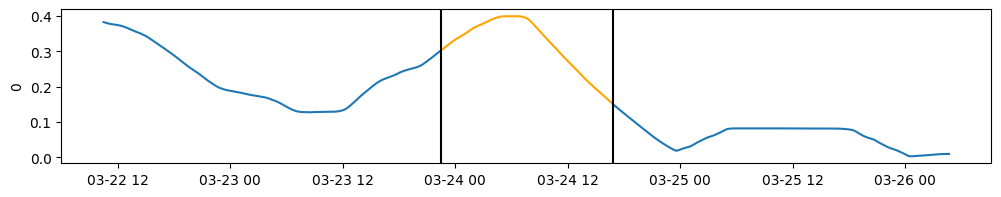

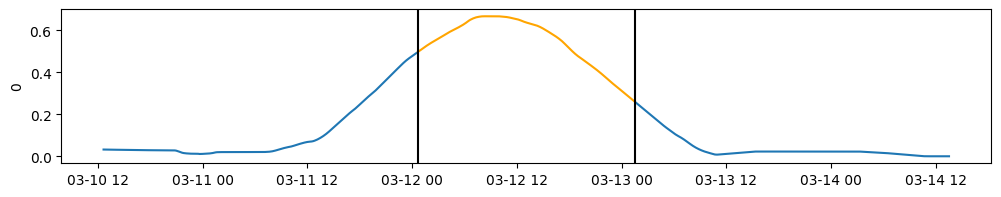

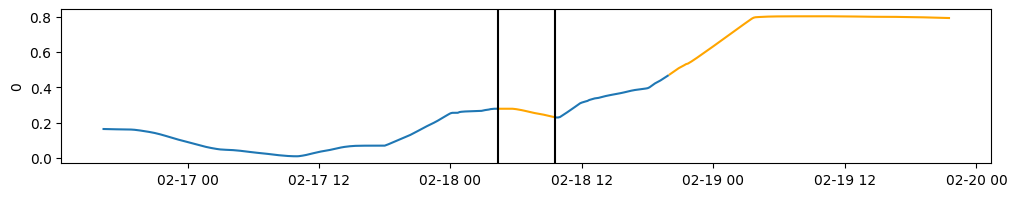

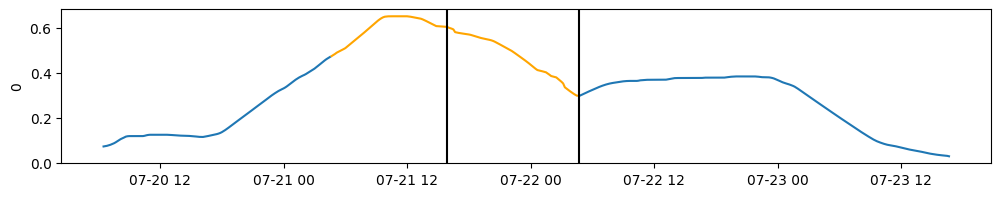

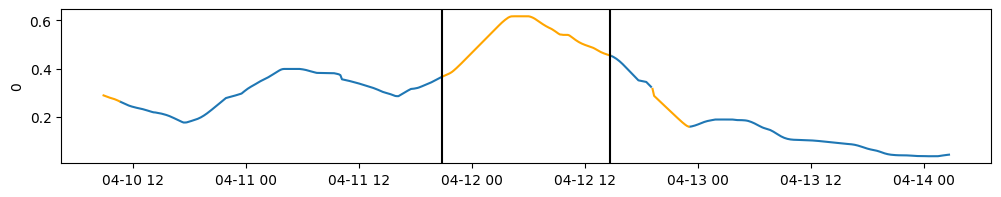

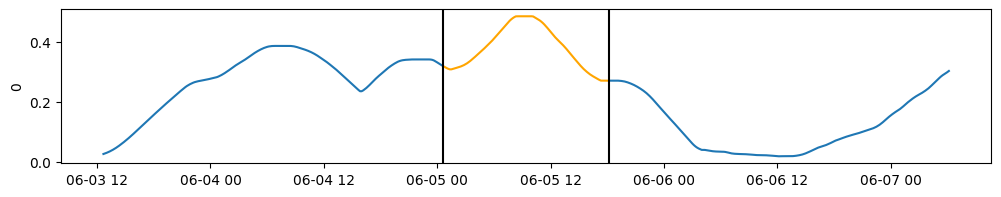

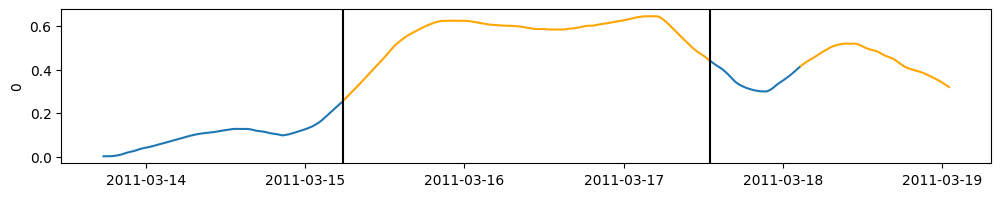

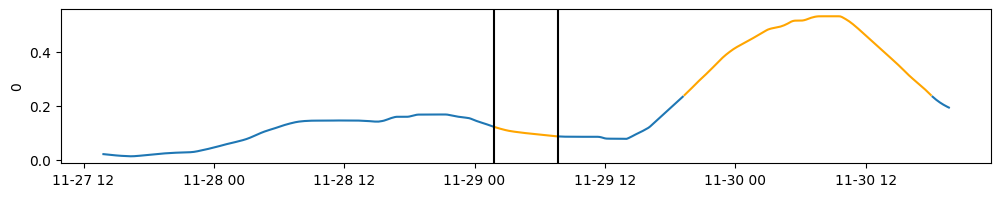

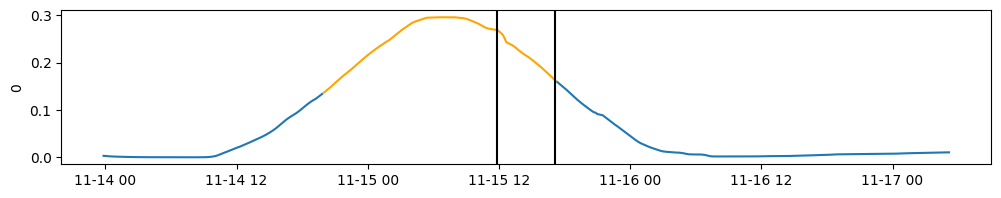

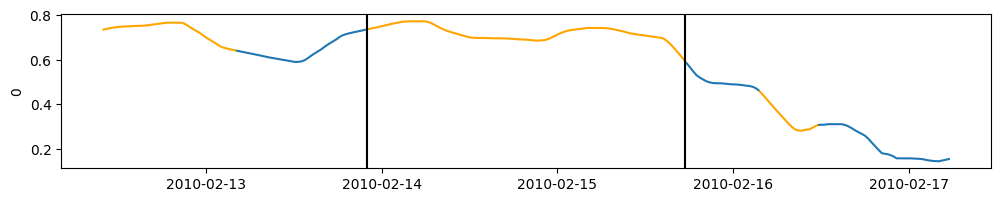

In [293]:
s_y_pred = pd.Series(y_pred[:, 1], index=labels_test.index)
s_y_pred = s_y_pred.rolling('18 h', center=True).mean()
s_y_pred_smoothed = s_y_pred.rolling(12, min_periods=0, center=True).quantile(0.90)

multiple_plots(
    s_y_pred_smoothed.to_frame(),
    labels_test,
    n_events=10,
    events=turn_prediction_to_event_list(labels_test),
    delta=36,
    figsize=(12, 2),
    random_state=2
)

<AxesSubplot: >

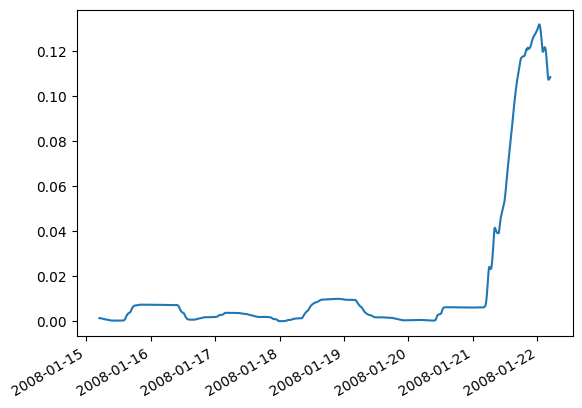

In [246]:
s_y_pred.rolling('20 h', center=True).mean().iloc[2000:3000].plot()

<AxesSubplot: >

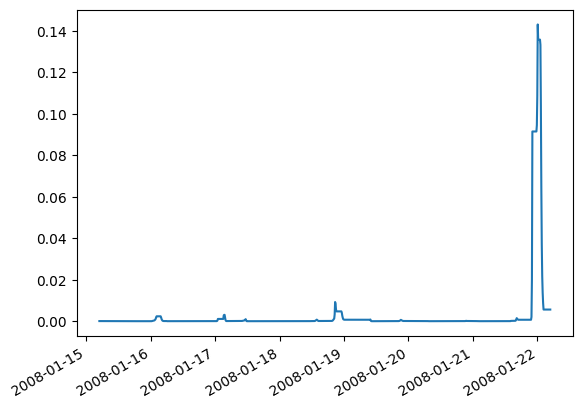

In [245]:
s_y_pred.rolling('5h', center=True).min().iloc[2000:3000].plot()